处理后有效记录数: 18839
空文本数量: 0

发现显著共现词组数量: 1123
Top 20显著共现词组:
social media: 2862次
large scale: 1052次
real world: 1028次
social networks: 964次
results show: 889次
machine learning: 870次
state art: 833次
social network: 832次
et al: 719次
real time: 576次
http www: 534次
decision making: 524次
full text: 517次
long term: 515次
results suggest: 484次
www org: 479次
natural language: 477次
google scholar: 450次
online social: 428次
find information: 422次


C:\Users\昳澄\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35789 (\N{CJK UNIFIED IDEOGRAPH-8BCD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\昳澄\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\昳澄\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\昳澄\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\昳澄\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarni

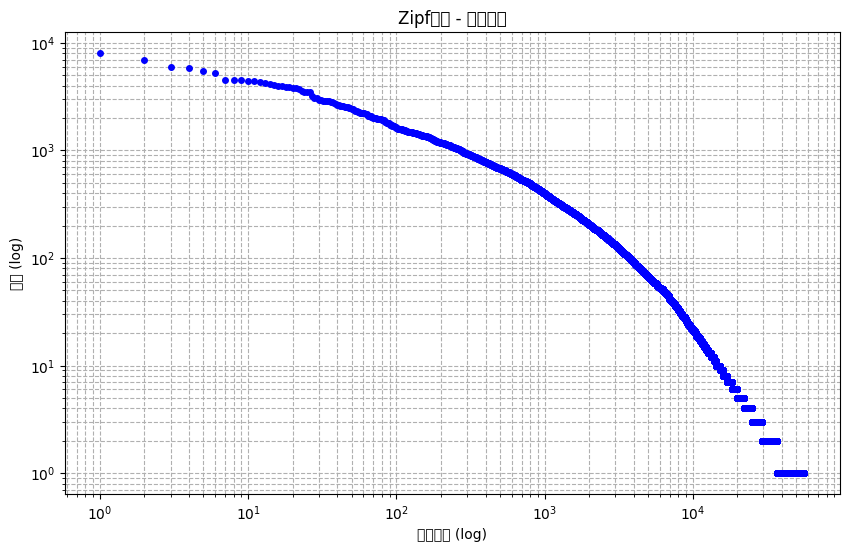

C:\Users\昳澄\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\昳澄\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\昳澄\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


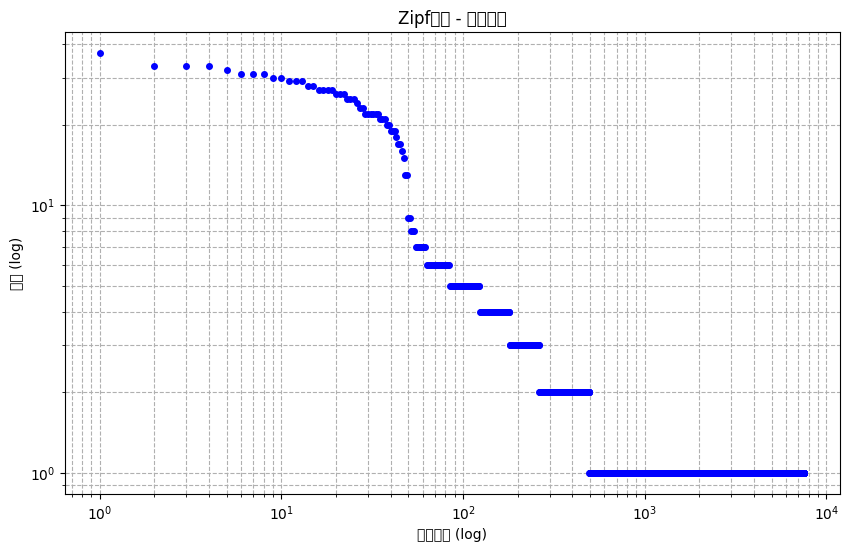


处理完成，结果已保存至 processed_abstracts_enhanced.csv


In [1]:
import pandas as pd  
import ast  
import re  
from collections import Counter  
from nltk.tokenize import RegexpTokenizer, MWETokenizer  
from nltk.corpus import stopwords  
from scipy.stats import chi2  
import matplotlib.pyplot as plt  
import random  
import numpy as np  

# 初始化NLTK组件  
stop_words = set(stopwords.words('english'))  
base_tokenizer = RegexpTokenizer(r'\b[a-zA-Z]{2,}\b')  # 匹配2个字母以上的单词  

# --------------------------  
# 增强版倒排索引转换函数  
# --------------------------  
def invert_index_to_text(inv_index):  
    """将倒排索引转换为原始文本（含错误处理）"""  
    # 处理空值和无效类型  
    if pd.isna(inv_index) or not isinstance(inv_index, str):  
        return ""  
    
    try:  
        index_dict = ast.literal_eval(inv_index)  
    except (SyntaxError, ValueError, TypeError):  
        return ""  
    
    # 验证字典结构  
    if not isinstance(index_dict, dict):  
        return ""  
    
    position_word = {}  
    conflict_count = 0  
    for word, positions in index_dict.items():  
        if not isinstance(positions, list):  # 处理异常位置格式  
            continue  
        for pos in positions:  
            if pos in position_word:  
                conflict_count += 1  
            position_word[pos] = word  # 保留最后出现的词  
    
    # 生成有序文本  
    sorted_positions = sorted(position_word.keys())  
    text = ' '.join(position_word[pos] for pos in sorted_positions)  
    
    return text  

# --------------------------  
# 数据加载与预处理  
# --------------------------  
# 读取数据并过滤空值  
file_path = r"C:\Users\昳澄\Desktop\course\DTU exchange\computational social science\讲座\IC2S2_abstracts.csv"  
df = pd.read_csv(file_path).dropna(subset=['abstract_inverted_index'])  
df['text'] = df['abstract_inverted_index'].apply(invert_index_to_text)  

# 数据质量检查  
print(f"处理后有效记录数: {len(df)}")  
print(f"空文本数量: {df['text'].isna().sum()}")  

# --------------------------  
# 增强版Tokenization处理  
# --------------------------  
def robust_tokenize(text):  
    """带错误处理的tokenization"""  
    if pd.isna(text) or not isinstance(text, str):  
        return []  
    
    try:  
        tokens = base_tokenizer.tokenize(text.lower())  
        return [t for t in tokens   
                if t not in stop_words   
                and len(t) > 1  
                and not re.match(r'\d+', t)]  
    except Exception as e:  
        print(f"Tokenization error: {str(e)}")  
        return []  

df['tokens'] = df['text'].apply(robust_tokenize)  

# --------------------------  
# Bigrams分析模块  
# --------------------------  
# 生成所有有效bigrams  
all_bigrams = []  
for tokens in df['tokens']:  
    if len(tokens) >= 2:  
        all_bigrams.extend(zip(tokens[:-1], tokens[1:]))  

# 统计词频（带过滤）  
token_counts = Counter(t for tokens in df['tokens'] for t in tokens)  
N = sum(len(tokens) for tokens in df['tokens'])  # 总token数  

# 卡方检验计算  
collocations = []  
for (bigram, o11) in Counter(all_bigrams).most_common():  
    if o11 <= 50:  
        continue  
    
    w1, w2 = bigram  
    count_w1 = token_counts[w1]  
    count_w2 = token_counts[w2]  
    
    # 计算观察值  
    o12 = count_w1 - o11  
    o21 = count_w2 - o11  
    o22 = N - o11 - o12 - o21  
    
    # 计算期望值  
    e11 = (count_w1 * count_w2) / N  
    expected_values = [e11, (count_w1 - e11), (count_w2 - e11), (N - count_w1 - count_w2 + e11)]  
    
    # 过滤无效期望值  
    if any(e < 1e-6 for e in expected_values):  
        continue  
    
    # 计算卡方统计量  
    chi2_val = sum((o - e)**2 / e for o, e in zip([o11, o12, o21, o22], expected_values))  
    p_value = chi2.sf(chi2_val, df=1)  
    
    if p_value < 0.001:  
        collocations.append((bigram, o11, chi2_val, p_value))  

# 结果处理与展示  
collocations.sort(key=lambda x: -x[1])  
print(f"\n发现显著共现词组数量: {len(collocations)}")  
print("Top 20显著共现词组:")  
for bg, cnt, _, _ in collocations[:20]:  
    print(f"{bg[0]} {bg[1]}: {cnt}次")  

# --------------------------  
# MWETokenizer应用  
# --------------------------  
mwe = MWETokenizer([tuple(bg) for (bg, *_) in collocations])  
df['new_tokens'] = df['tokens'].apply(lambda x: mwe.tokenize(x))  

# --------------------------  
# Zipf定律分析模块  
# --------------------------  
def analyze_zipf(tokens_list, title):  
    """生成Zipf分布分析图表"""  
    freq = Counter(tokens_list)  
    ranks = np.arange(1, len(freq)+1)  
    frequencies = np.array(sorted(freq.values(), reverse=True))  
    
    plt.figure(figsize=(10, 6))  
    plt.loglog(ranks, frequencies, 'bo', markersize=4)  
    plt.title(f"Zipf分布 - {title}")  
    plt.xlabel('词频排名 (log)')  
    plt.ylabel('词频 (log)')  
    plt.grid(True, which="both", ls="--")  
    plt.show()  

# 生成随机文本对比  
random.seed(42)  
random_text = ''.join(random.choices('abcdefg ', k=100000))  
random_tokens = base_tokenizer.tokenize(random_text.lower())  

# 分析对比  
analyze_zipf([t for tokens in df['new_tokens'] for t in tokens], "论文摘要")  
analyze_zipf(random_tokens, "随机文本")  

# --------------------------  
# 数据保存  
# --------------------------  
df.to_csv('processed_abstracts_enhanced.csv', index=False)  
print("\n处理完成，结果已保存至 processed_abstracts_enhanced.csv")  